In [1]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
import random
import pickle
import numpy as np
import pandas as pd

import torch
import pytorch_lightning as pl
import argparse
# module with datasets definition = train, validation and test
import DataHelperFusion as DH
import SASRecNOVAModel2 as SASRec
import torch.optim as optim
import torch.nn.functional as F
from pytorch_lightning.callbacks import ModelCheckpoint, StochasticWeightAveraging

# from torch.nn import MultiheadAttention, LayerNorm, Dropout, Conv1d, Embedding, BCEWithLogitsLoss
from torch.nn import LayerNorm, Dropout, Conv1d, Embedding, BCEWithLogitsLoss
from SASRecNOVAModel2 import PointWiseFF, SASRecEncoderLayer, PositinalEncoder, SASRecEncoder

2022-06-28 16:29:38.649386: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/extras/CUPTI/lib64:/usr/local/cuda/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2022-06-28 16:29:38.649413: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (15.0, 8.0)

rows = 2
columns = 5

In [3]:
# setup command line arguments
parser = argparse.ArgumentParser()
parser.add_argument('--dataset', default='Luxury_Beauty', 
                    required=True, 
                    help="dataset to use : Beauty, ml-1m(default), Steam or Video")

parser.add_argument('--maxlen', default=50, type=int, 
                    help="truncate input sequence to last maxlen items, default 50")
parser.add_argument('--hidden_units', default=50, type=int, help="synonym for d_model") # synonym for d_model
parser.add_argument('--d_model', default=50, type=int, 
                    help="Transformer internal dimention") # same as hidden_units   
parser.add_argument('--num_blocks', default=2, type=int, help="Number of blocks in Transformer")
parser.add_argument('--num_heads', default=1, type=int, help="Number of heads in self-attention")
parser.add_argument('--dropout_rate', default=0.5, type=float, help="Dropout rate for Transformer")
parser.add_argument('--l2_pe_reg', default=0.1, type=float, help="Regularization for positional embedding")

parser.add_argument('--ndcg_samples', default=100, type=int, 
                    help="How many random items to pick up in hit-rate and ndcg calculation, default 100")
parser.add_argument('--top_k', default=10, type=int, 
                    help="How many items with high scores to pick for hit-rate and ndcg calculation, default 10")
parser.add_argument('--opt', default='Adam', type=str, help="Oplimizer to use: Adam(default), AdmaW, FusedAdam(requires apex library)")
parser.add_argument('--lr', default=0.001, type=float, 
                    help="learning rate, default 0.001")
parser.add_argument('--weight_decay', default=0.001, type=float, help="Weight decay for AdmaW")
parser.add_argument('--batch_size', default=128, type=int)
parser.add_argument('--warmup_proportion', default=0.2, type=float, help="Fraction of total optimization steps to increase learning rate from zero to max value")
# for different optimizers - regular Adam uses num_epochs and LAMB uses max_iters
parser.add_argument('--max_iters', default=10000, type=int, help="Optimization budget in update iterations")
parser.add_argument('--num_epochs', default=201, type=int, help="Number of epochs to train")
# swa parameters
parser.add_argument('--use_swa', default=False, type=bool, help="Use Stochastic Weights Ageraging algorythm")
parser.add_argument('--swa_epoch_start', default=0.8, type=float, help="Start SWA after that part of total epochs")
parser.add_argument('--swa_annealing_epochs', default=10, type=int, help="Number of epochs in the annealing phase of SWA")

# xavier init
parser.add_argument('--xavier_init', default=True, type=bool, help="Use xavier normal to init the model")

parser.add_argument('--inference_only', default=False, type=bool)
parser.add_argument('--checkpoint_path', default=None, type=str, help="Path to lightning checkpoint file")
parser.add_argument('--strategy', default='ddp_spawn', type=str, help="Lightning parallel training strategy dp, ddp, ddp_spawn(default), ddp2, etc ")
parser.add_argument('--precision', default=16, type=int, help="Lightning precision for model data during trining 16(default) or 32")
parser.add_argument('--accelerator', default="auto", type=str, help="Lightning accelerator auto(defaut), cpu, gpu, tpu")
parser.add_argument('--devices', default="auto", type=str, 
                    help="Lightning devices to use - see https://pytorch-lightning.readthedocs.io/en/stable/common/trainer.html#devices")
parser.add_argument('--fusion', default="concat", type=str, 
                    help="fusion method")

args = parser.parse_args( ['--dataset=ml-1m', '--maxlen=200', '--dropout_rate=0.2'])
args = vars(args)

In [4]:
args['dataset'] = 'Luxury_Beauty'; args['maxlen'] = 50; args['dropout_rate'] = 0.5;
args['fusion'] = 'gate'

In [5]:
# read dataset
dataset = DH.data_partition(args['dataset'])
[user_train, user_valid, user_test, usernum, itemnum] = dataset

In [6]:
usernum, itemnum

(3362, 1494)

In [7]:
# model load
model = SASRecEncoder(itemnum, args['fusion'], **args)
model.load_state_dict(torch.load('weight/Luxury_Beauty_95.pt'))

In [8]:
# batches got sliced by users, i.e. batch accumulate BATCH_SIZE user sequences of items selected/bought
BATCH_SIZE = args['batch_size']
num_batch = len(user_train) // BATCH_SIZE  # number of batches

user_train_lens = list(map(len,[v for k,v in user_train.items()]))
print(f'average sequence length: {sum(user_train_lens)/len(user_train):.1f}')

average sequence length: 7.1


In [18]:
test_loader = torch.utils.data.DataLoader(dataset=DH.SequenceDataTest(user_train, user_valid, user_test, usernum, itemnum, args['maxlen'], args['ndcg_samples']), 
                                          batch_size=args['batch_size'], shuffle=True, 
                                          drop_last=True)

100%|██████████| 3362/3362 [00:00<00:00, 4802.57it/s]


In [19]:
for seq_test, valid_test, image_feature_test, text_feature_test in test_loader:
    break

### Recommendation visualization

In [12]:
with open('data/Luxury_Beauty_itemmap.pkl', 'rb') as f:
    itemmap = pickle.load(f)

In [13]:
meta = pd.read_csv('data/Luxury_Beauty_after_meta.csv')

In [20]:
with torch.no_grad():
    input_emb = model(seq_test, image_feature_test, text_feature_test)
    final_feat = input_emb[:, -1, :]
    val_test_emb = model.ie(valid_test)
    logits = torch.bmm(val_test_emb, final_feat.unsqueeze(-1))
    predictions = -logits.squeeze()
    GROUND_TRUTH_IDX = 0

    _, indices = torch.topk(predictions, 10, dim=1, largest=False)    
    
    _, rank = torch.where(indices == GROUND_TRUTH_IDX)

In [27]:
random_user = random.randint(0, 127)

# 실제로 구매한 아이템
interaction = meta.loc[meta['asin'].isin(seq_test[random_user].detach().numpy())].reset_index(drop = True)

# 추천 아이템
recommend = meta.loc[meta['asin'].isin(valid_test[random_user][indices[random_user]].detach().numpy())].reset_index(drop = True)

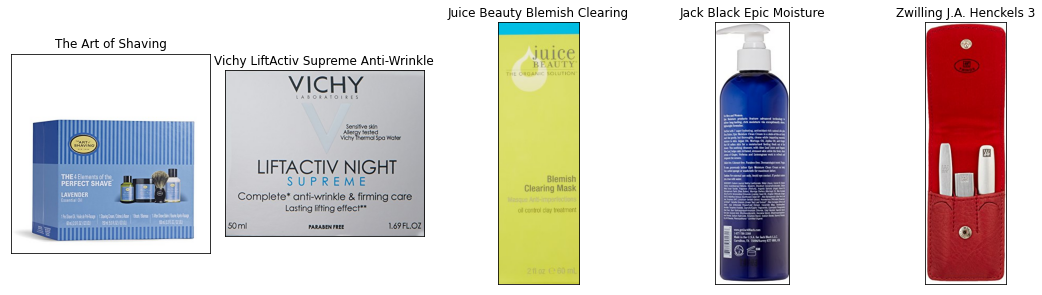

In [28]:
# 이전 구매한 아이템
for n, i in enumerate(interaction['asin']):
    image = Image.open(f"data/Luxury_Beauty_image_folder/{i}.png")
    image_index = n + 1
    title = ' '.join(interaction.loc[interaction['asin'] == i]['title'].values[0].split()[:4])
    plt.subplot(rows, columns, image_index) # subplot 
    plt.title(title)   # title 
    plt.xticks([])  # x = None 
    plt.yticks([])  # y = None
    plt.imshow(image)  
    plt.tight_layout()

plt.show()

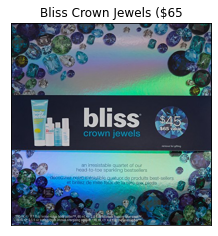

In [29]:
# test 검증시 실제 구매한 아이템
for n, i in enumerate(range(10)):
    real_item = valid_test[random_user][0].detach().numpy()
    image = Image.open(f"data/Luxury_Beauty_image_folder/{real_item}.png")
    title = ' '.join(meta.loc[meta['asin'] == real_item]['title'].values[0].split()[:4])
    plt.subplot(rows, columns, image_index) # subplot 
    plt.title(title)   # title 
    plt.xticks([])  # x = None 
    plt.yticks([])  # y = None
    plt.imshow(image)  
    plt.tight_layout()
plt.show()

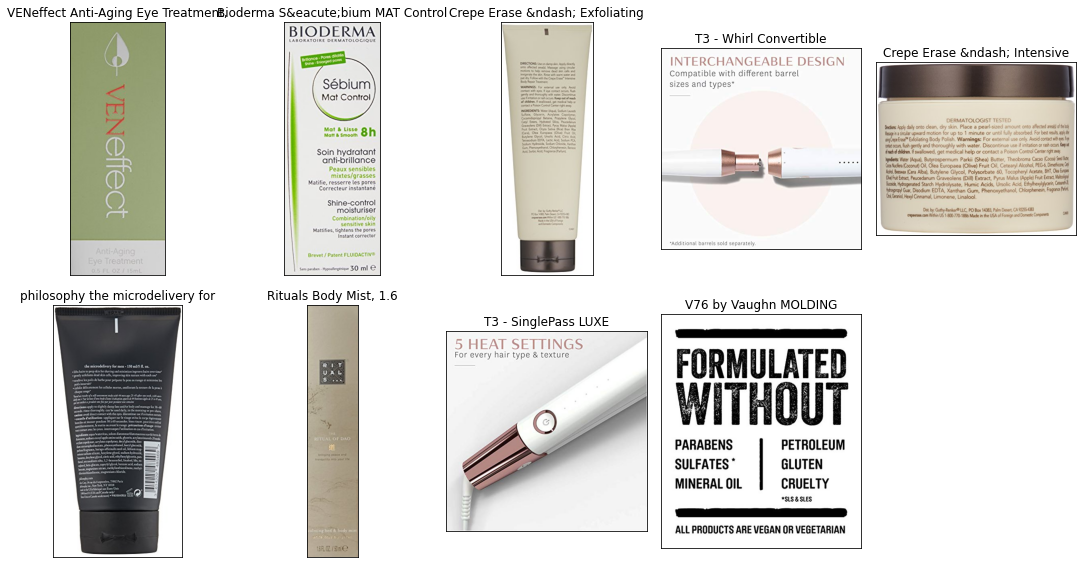

In [31]:
# 추천 아이템 
for n, i in enumerate(recommend['asin']):
    image = Image.open(f"data/Luxury_Beauty_image_folder/{i}.png")
    image_index = n + 1
    title = ' '.join(recommend.loc[recommend['asin'] == i]['title'].values[0].split()[:4])
    plt.subplot(rows, columns, image_index) # subplot 
    plt.title(title)   # title 
    plt.xticks([])  # x = None 
    plt.yticks([])  # y = None
    plt.imshow(image)  
    plt.tight_layout()

plt.show()

### 모든 이미지 저장

In [ ]:
# from urllib.request import urlopen
# import urllib
# import cv2

# from PIL import Image

In [ ]:
# def url_to_image(url, readFlag=cv2.IMREAD_COLOR):
#     # download the image, convert it to a NumPy array, and then read
#     # it into OpenCV format
#     resp = urllib.request.urlopen(url)
#     image = np.asarray(bytearray(resp.read()), dtype="uint8")
#     image = cv2.imdecode(image, cv2.IMREAD_COLOR)

#     # return the image
#     return image

In [171]:
# for n, url in enumerate(meta['imageURLHighRes']):
#     cv2.imwrite(f'data/Luxury_Beauty_image_folder/{n+1}.png',
#                url_to_image(url.split()[0][2:-2]))